# Chapter 12 Cross-Validation and Model Evaluation Techniques
This notebook provides practical "recipes" for cross-validation and model evaluation techniques. Each recipe includes explanations, code examples, visualizations, best practices, and common pitfalls when applicable. 

Cross-validation is a cornerstone technique for assessing how a machine learning model will perform on unseen data. Instead of relying on a single train-test split, we divide the dataset into multiple subsets, training and validating the model several times to get a better estimate of its generalization ability. In this recipe, we’ll explore different types of cross-validation, including k-fold and stratified k-fold cross-validation, and walk through how to implement them using scikit-learn.

## Getting ready
We begin by loading the libraries and dataset we’ll use to demonstrate cross-validation strategies. We’ll use a classification dataset generated by make_classification.

In [1]:
# Load the libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
X, y = make_classification(n_samples=500, n_features=10, n_informative=8,
                           n_redundant=2, n_classes=2, random_state=2024)

## How to do it...
We’ll apply k-fold and stratified k-fold cross-validation to evaluate a logistic regression model.

In [2]:
# Initialize the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=2024)

# Iterate through the folds and evaluate
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
print(f"Average accuracy (KFold): {np.mean(accuracies):.3f}")

# Use stratified k-fold for balanced class splits
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
strat_accuracies = []
for train_index, test_index in strat_kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    strat_accuracies.append(accuracy_score(y_test, y_pred))
print(f"Average accuracy (StratifiedKFold): {np.mean(strat_accuracies):.3f}")

Average accuracy (KFold): 0.756
Average accuracy (StratifiedKFold): 0.766


## How it works...
Standard k-fold cross-validation splits the data into k equally sized parts, trains the model on k-1 parts, and tests it on the remaining part—repeating this process k times. However, in classification problems, especially with imbalanced classes, this might lead to folds that do not represent the overall class distribution.
Stratified k-fold solves this by preserving the percentage of samples for each class in each fold. This provides a more reliable estimate of the model’s performance across imbalanced classes.
The output prints the average classification accuracy across folds for both approaches. In most imbalanced cases, stratified k-fold yields more stable and fair evaluation results.

# Advanced Cross-Validation Methods
When we’re working with complex models or small datasets, basic cross-validation strategies like k-fold might not provide the control or precision we need. In this recipe, we’ll explore two advanced techniques—leave-one-out cross-validation (LOOCV) and nested cross-validation. LOOCV is useful when we want to make the most out of limited data, while nested cross-validation helps us tune hyperparameters without data leakage between model selection and evaluation.

## Getting ready
To begin, we’ll load a small dataset and set up the libraries needed for LOOCV and nested cross-validation. We’ll use ridge regression for demonstration, which benefits from regularization tuning.

In [3]:

# Load the libraries
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import LeaveOneOut, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge

# Load the dataset
data = load_diabetes()
X = data.data
y = data.target

## How to do it...
We’ll walk through both leave-one-out and nested cross-validation with scikit-learn.

In [4]:
# Apply Leave-One-Out cross-validation with MSE scoring
loo = LeaveOneOut()
model = Ridge(alpha=1.0)
scores = cross_val_score(model, X, y, cv=loo, scoring="neg_mean_squared_error")
print(f"LOOCV mean MSE: {-np.mean(scores):.3f}")

# Define a grid for hyperparameter tuning
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Apply nested cross-validation using GridSearchCV (default scoring is fine for outer CV)
nested_scores = cross_val_score(
    GridSearchCV(Ridge(), param_grid, cv=5), X, y, cv=5
)
print(f"Nested CV mean score: {np.mean(nested_scores):.3f}")

LOOCV mean MSE: 3327.655
Nested CV mean score: 0.480


## How it works...
Leave-one-out cross-validation performs model evaluation by training on all data points except one, using the held-out point for testing. It repeats this for every data point, providing nearly unbiased estimates but at a higher computational cost.
Nested cross-validation is useful when tuning hyperparameters. An inner loop performs model selection (e.g., grid search) while the outer loop evaluates model performance. This prevents overfitting to the test set during hyperparameter tuning, yielding a more honest estimate of generalization performance. The printed results will include the mean scores from both LOOCV and nested CV evaluations. Because nested CV handles tuning and evaluation in isolated folds, it’s often preferred in model development pipelines.

# Implementing Cross-Validation in Scikit-Learn
Once we understand the theory and importance of cross-validation, the next step is to put it into practice. scikit-learn offers streamlined tools to implement different cross-validation workflows. In this recipe, we’ll walk through setting up basic and advanced cross-validation loops using cross_val_score(), cross_validate(), and GridSearchCV() to assess and compare model performance.

## Getting ready
We’ll use a classification problem as our basis and load the necessary tools from scikit-learn to apply cross-validation.

In [5]:
# Load the libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

# Load and prepare the dataset
X, y = make_classification(n_samples=500, n_features=10, weights=[0.7, 0.3], random_state=2024)

## How to do it...
We’ll demonstrate three ways to perform cross-validation using scikit-learn’s high-level API.

In [6]:
# Use cross_val_score() to compute average accuracy
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Mean accuracy: {np.mean(scores):.3f}")

# Use cross_validate() to compute multiple metrics
results = cross_validate(model, X, y, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1'])
print(f"Mean precision: {np.mean(results['test_precision']):.3f}")
print(f"Mean recall: {np.mean(results['test_recall']):.3f}")
print(f"Mean F1: {np.mean(results['test_f1']):.3f}")

# Use GridSearchCV() for hyperparameter tuning with cross-validation
param_grid = {"C": [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X, y)
print(f"Best hyperparameter (C): {grid.best_params_['C']}")
print(f"Best accuracy: {grid.best_score_:.3f}")

Mean accuracy: 0.910
Mean precision: 0.875
Mean recall: 0.820
Mean F1: 0.845
Best hyperparameter (C): 0.1
Best accuracy: 0.918


## How it works...
cross_val_score() provides a quick way to evaluate a model with a single metric using cross-validation. cross_validate() is more flexible, allowing multiple metrics to be captured simultaneously.
GridSearchCV() integrates cross-validation with hyperparameter search. It performs model training and evaluation on every combination of specified hyperparameters and selects the best based on the scoring metric.
This approach helps reduce overfitting and improves generalization by providing a more robust view of how a model will perform across different subsets of the data.

# Model Selection Techniques
Once we’ve evaluated our models using cross-validation, the next step is selecting the best one for deployment. Model selection techniques help us compare different algorithms and configurations in a statistically robust way. In this recipe, we’ll use grid search and randomized search to perform hyperparameter tuning and select the optimal model based on cross-validation scores.

## Getting ready
We’ll use a classification task and compare different regularization strengths for logistic regression using both exhaustive and randomized search strategies.

In [7]:
# Load the libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Load and split the dataset
X, y = make_classification(n_samples=500, n_features=10, weights=[0.7, 0.3], random_state=2024)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

## How to do it...
We’ll set up and compare both GridSearchCV and RandomizedSearchCV to find the best regularization strength for logistic regression.

In [8]:
# Use GridSearchCV to evaluate all combinations in the parameter grid
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print(f"GridSearchCV best C: {grid.best_params_['C']}")

# Use RandomizedSearchCV to evaluate a random sample of parameters
from scipy.stats import loguniform
param_dist = {"C": loguniform(1e-3, 1e2)}
random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist,
                                    n_iter=10, cv=5, scoring='accuracy', random_state=2024)
random_search.fit(X_train, y_train)
print(f"RandomizedSearchCV best C: {random_search.best_params_['C']:.4f}")

# Evaluate final model performance
final_model = random_search.best_estimator_
y_pred = final_model.predict(X_test)
print(f"Final accuracy on test set: {accuracy_score(y_test, y_pred):.3f}")

GridSearchCV best C: 0.1
RandomizedSearchCV best C: 0.1744
Final accuracy on test set: 0.940


## How it works...
GridSearchCV() performs an exhaustive search across the specified hyperparameter grid. While comprehensive, it can become computationally expensive as the number of parameters grows.
RandomizedSearchCV() samples a fixed number of parameter combinations from distributions we specify. It’s often more efficient and yields comparable results with fewer evaluations.
We use these tools to identify the model configuration that yields the best performance during cross-validation and then validate it on unseen test data.

# Evaluating Model Generalizability
A well-performing model on training and validation sets doesn’t always generalize well to unseen data. This recipe focuses on techniques to assess and ensure the generalization capability of machine learning models. We’ll explore learning curves, validation curves, and cross-validation strategies that help prevent overfitting and support robust model development.

## Getting ready
We’ll use a synthetic classification dataset and logistic regression to demonstrate how model performance changes with different amounts of training data and varying model complexity.

In [9]:
# Load the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, validation_curve

# Load the dataset
X, y = make_classification(n_samples=1000, n_features=20, weights=[0.7, 0.3], random_state=2024)

## How to do it...
We’ll start by plotting learning curves to understand how the model performs as the training size increases, and then plot a validation curve to evaluate model performance across different values of a key hyperparameter.

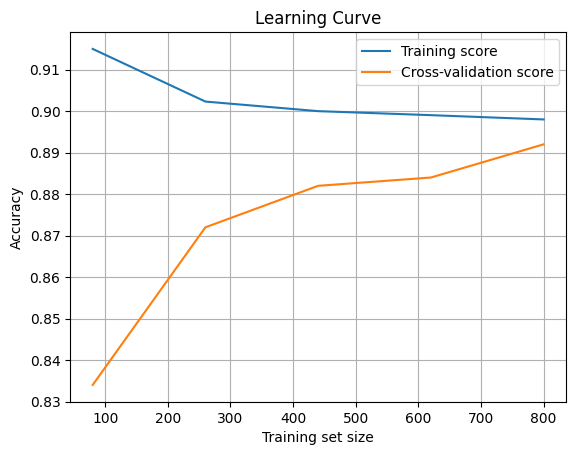

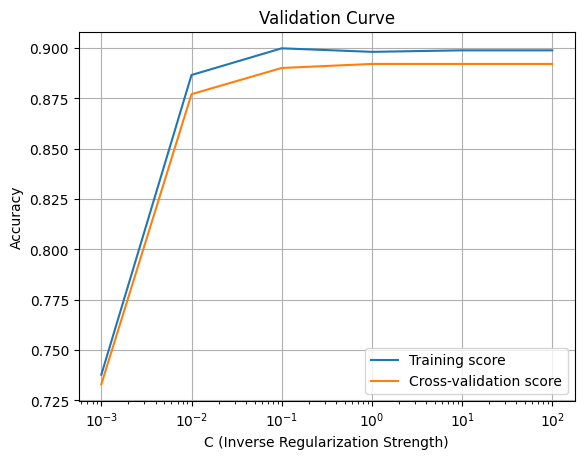

In [10]:
# Plot a learning curve
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(), X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=2024)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot a validation curve
param_range = np.logspace(-3, 2, 6)
train_scores, test_scores = validation_curve(
    LogisticRegression(), X, y, param_name="C", param_range=param_range,
    cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.semilogx(param_range, train_mean, label='Training score')
plt.semilogx(param_range, test_mean, label='Cross-validation score')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

## How it works...
The learning curve illustrates how training and validation accuracy evolve as more training data is used. A gap between the two lines often signals overfitting, while convergence suggests good generalization.
The validation curve helps identify whether the model is underfitting or overfitting at different levels of model complexity. For example, small values of C lead to strong regularization, potentially underfitting the data, while large values of C reduce regularization and may cause overfitting.
These diagnostics allow us to make data-driven decisions about model configuration and dataset sufficiency.

# Practical Exercises in Cross-Validation and Evaluation
In this final section, we’ll engage in practical exercises that involve building, tuning, and evaluating models using cross-validation and performance metrics. These exercises are designed to reinforce the concepts explored throughout the chapter, including model selection, hyperparameter tuning, and generalization evaluation. By completing these exercises, we’ll solidify our understanding of how to effectively assess model performance and select the best model for real-world applications.

## Exercise 1: Cross-Validating a Logistic Regression Model
We’ll evaluate a logistic regression classifier using k-fold cross-validation and report multiple metrics.

### Implementation Steps:

In [11]:
# Load libraries
YOUR CODE HERE

# Load the dataset
YOUR CODE HERE

# Cross-validate and collect metrics
YOUR CODE HERE


SyntaxError: invalid syntax (1704917209.py, line 2)

## Exercise 2: Tuning Hyperparameters with Grid Search
We’ll perform hyperparameter tuning using GridSearchCV and compare the results.

### Implementation Steps:

In [ ]:
# Load libraries
YOUR CODE HERE

# Load and split the dataset
YOUR CODE HERE

# Perform grid search
YOUR CODE HERE

# Evaluate on the test set
YOUR CODE HERE


## Exercise 3: Assessing Model Generalization with Learning and Validation Curves
We’ll use learning_curve and validation_curve to visualize how model performance varies with training size and model complexity.

### Implementation Steps:

In [ ]:
# Load libraries
YOUR CODE HERE


# Plot the learning curve
YOUR CODE HERE


# Plot the validation curve
YOUR CODE HERE
